In [59]:
from pathlib import Path

import numpy as np
import pypulseq as pp
from bmc.utils.seq.write import write_seq

import matplotlib.pyplot as plt

In [60]:
try:
    seqid = Path(__file__).stem + "_python"
    folder = Path(__file__).parent
except NameError:
    seqid = "default_seqid"
    folder = Path(".")

In [61]:
# general settings
AUTHOR = "DANIEL MIKSCH"
FLAG_PLOT_SEQUENCE = True  # plot preparation block?
FLAG_CHECK_TIMING = True  # perform a timing check at the end of the sequence?
FLAG_POST_PREP_SPOIL = True  # add spoiler after preparation block?

# sequence definitions
defs: dict = {}
defs["a"] = 90 # a in degrees
defs["b0"] = 17  # B0 [T]
defs["n_trains"] = 1  # number of pulses  #
defs["n_ETM"] = 50

defs["tmix"] = 2.17e-3  # time of exchange between pools (10ms) [s]
defs["trec"] = 2  # recovery time [s]
defs["tETM"] = 0.9e-3 # intermodule delay between rf pulse and gradient
defs["tRead"] = 0.92e-3 # delay between read rf pulse and gradient

# defs["trec_m0"] = 12  # recovery time before M0 [s]
defs["m0_offset"] = -6.6  # m0 offset [ppm]
defs["offsets_ppm"] = np.append(defs["m0_offset"], np.linspace(-6, 6, 163))

# defs["num_meas"] = defs["offsets_ppm"].size  # number of repetition -> Reverse

defs["num_meas"] = defs["offsets_ppm"].size  # number of repetition
# defs["tsat"] = defs["tp"]  # saturation time [s]
defs["seq_id_string"] = seqid  # unique seq id
# defs["spoiling"] = "1" if FLAG_POST_PREP_SPOIL else "0"

seq_filename = defs["seq_id_string"] + ".seq"

defs["tp"] = 1  # pulse duration [s]
defs["b1pa"] = 3.7  # B1 peak amplitude [µT]

In [62]:
sys = pp.Opts(
    max_grad=1250,
    grad_unit="mT/m",
    max_slew=1000,
    slew_unit="T/m/s",
    rf_ringdown_time=0,
    rf_dead_time=0,
    rf_raster_time=1e-6,
    gamma=42576400,
)

GAMMA_HZ = sys.gamma * 1e-6
defs["freq"] = defs["b0"] * GAMMA_HZ  # Larmor frequency [Hz]

In [63]:
# ===========
# PREPARATION
# ===========

spoil_amp = 0.8 * sys.max_grad  # Hz/m
rise_time = 1.0e-3  # spoiler rise time in seconds
spoil_dur = 6.5e-3  # complete spoiler duration in seconds

gx_spoil, gy_spoil, gz_spoil = [
    pp.make_trapezoid(channel=c, system=sys, amplitude=spoil_amp, duration=spoil_dur, rise_time=rise_time)
    for c in ["x", "y", "z"]
]

# spoiler
spoil_amp = 0.8 * sys.max_grad  # Hz/m
rise_time = 0e-3  # spoiler rise time in seconds
spoil_dur = 5e-3  # complete spoiler duration in seconds
gmix_duration = 2e-3


# rf pulse
flip_angle = np.radians(defs['a'])
t_pulse = 1.83e-3
t_pulse_read = 3.6e-3
# bandwidth_read = 

flip_angle_sat = defs["b1pa"] * GAMMA_HZ * 2 * np.pi * defs["tp"]
sat_pulse = pp.make_block_pulse(flip_angle=flip_angle_sat, duration=defs["tp"], system=sys)

rf_90 = sinc = pp.make_sinc_pulse(
    flip_angle=flip_angle,
    system=sys,
    duration=10e-3,         # Bandbreite in Hz
    center_pos=0.5,
    freq_offset=0,
    phase_offset=0,
    return_gz=False)

rf_180 = sinc = pp.make_sinc_pulse(
    flip_angle=np.radians(180),
    system=sys,
    duration=2.5e-3,         # Bandbreite in Hz
    center_pos=0.5,
    freq_offset=0,
    phase_offset=0,
    return_gz=False)


#pseudo adc
pseudo_adc = pp.make_adc(num_samples=2048, duration=1e-3)

# delays
tmix_delay = pp.make_delay(defs["tmix"])
trec_delay = pp.make_delay(defs["trec"])
delay_ETM = pp.make_delay(defs["tETM"])
delay_read = pp.make_delay(defs["tRead"])



In [64]:
seq = pp.Sequence()

offsets_hz = defs["offsets_ppm"] * defs["freq"]  # convert from ppm to Hz

In [65]:
for m, offset in enumerate(offsets_hz):
    # print progress/offset
    print(f"#{m + 1} / {len(offsets_hz)} : offset {offset / defs['freq']:.2f} ppm ({offset:.3f} Hz)")

    sat_pulse.freq_offset = offset
    rf_90.freq_offset = 0

    # seq.add_block(delay_ETM)
    seq.add_block(sat_pulse)
        # _, _, gz = [
        # pp.make_trapezoid(channel=c, system=sys, amplitude=0, duration=spoil_dur, rise_time=rise_time)
        # for c in ["x", "y", "z"]
        # ]
        # seq.add_block(gz)
        # add pseudo ADC event
    # seq.add_block(tmix_delay)
    # rf_pulse.freq_offset = 0
    # seq.add_block(delay_read)
    # seq.add_block(rf_90)
    # seq.add_block(trec_delay)
    seq.add_block(pseudo_adc)
    # seq.add_block(trec_delay)

if FLAG_CHECK_TIMING:
    ok, error_report = seq.check_timing()
    if ok:
        print("\nTiming check passed successfully")
    else:
        print("\nTiming check failed! Error listing follows\n")
        print(error_report)

#1 / 164 : offset -6.60 ppm (-4777.072 Hz)
#2 / 164 : offset -6.00 ppm (-4342.793 Hz)
#3 / 164 : offset -5.93 ppm (-4289.178 Hz)
#4 / 164 : offset -5.85 ppm (-4235.563 Hz)
#5 / 164 : offset -5.78 ppm (-4181.949 Hz)
#6 / 164 : offset -5.70 ppm (-4128.334 Hz)
#7 / 164 : offset -5.63 ppm (-4074.719 Hz)
#8 / 164 : offset -5.56 ppm (-4021.104 Hz)
#9 / 164 : offset -5.48 ppm (-3967.490 Hz)
#10 / 164 : offset -5.41 ppm (-3913.875 Hz)
#11 / 164 : offset -5.33 ppm (-3860.260 Hz)
#12 / 164 : offset -5.26 ppm (-3806.646 Hz)
#13 / 164 : offset -5.19 ppm (-3753.031 Hz)
#14 / 164 : offset -5.11 ppm (-3699.416 Hz)
#15 / 164 : offset -5.04 ppm (-3645.801 Hz)
#16 / 164 : offset -4.96 ppm (-3592.187 Hz)
#17 / 164 : offset -4.89 ppm (-3538.572 Hz)
#18 / 164 : offset -4.81 ppm (-3484.957 Hz)
#19 / 164 : offset -4.74 ppm (-3431.342 Hz)
#20 / 164 : offset -4.67 ppm (-3377.728 Hz)
#21 / 164 : offset -4.59 ppm (-3324.113 Hz)
#22 / 164 : offset -4.52 ppm (-3270.498 Hz)
#23 / 164 : offset -4.44 ppm (-3216.884 H

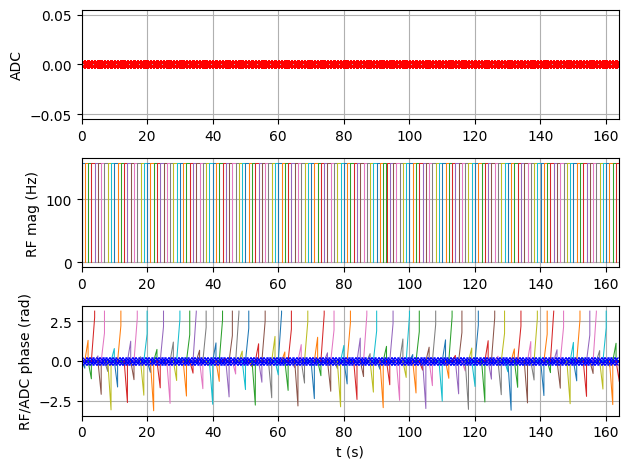

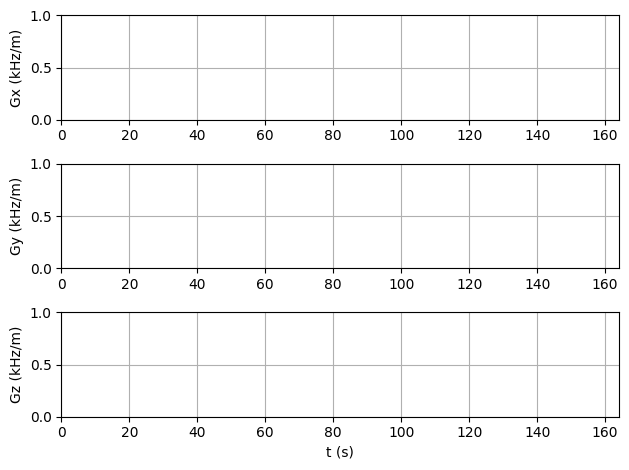

In [66]:
if FLAG_PLOT_SEQUENCE:
    seq.plot() #time_range=[0.00, .03]

In [67]:
write_seq(seq=seq, seq_defs=defs, filename=folder / seq_filename, author=AUTHOR, use_matlab_names=True)